# Version 4: Advanced Evolutionary Strategies (ES)
* Implement an advanced version of ES, incorporating techniques like self-
adaptive mutation rates or more sophisticated recombination methods

In [10]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from statisticscalc import analyze_convergence, validate_and_plot

In [19]:
# Load data and set parameter values

# Load monthly returns data
monthly_returns_df = pd.read_csv('data/monthlyreturn/monthlyreturnstocks.csv')
monthly_returns_df = monthly_returns_df.select_dtypes(include=[np.number])  # Keep only numeric columns

# Parameters
population_size = 100 # Number of portfolios
offspring_size = 90  # 90% recombination
elitism_size = 10    # 10% elitism
num_generations = 1000 # Number of generations
mutation_rate = 0.5 # Base mutation rate
num_months = len(monthly_returns_df)  # Total months in the dataset
num_assets = monthly_returns_df.shape[1]  # Number of stocks/assets
cov_matrix = monthly_returns_df.cov().to_numpy()

# Advanced ES functions
* Here we are implementing adaptive mutation rates for each individual. We will have 1 rate for each individual
* We are still using the same recombination logic.

In [20]:
# Initialize population with random portfolio allocations that sum to 1 each month
def initialize_population(size, num_months, num_assets):
    # New addition: Adding mutation steps as well for each idividual portfolio
    population = [np.array([np.random.dirichlet(np.ones(num_assets)) for _ in range(num_months)]) for _ in range(size)]
    mutation_steps = [np.full((num_months, num_assets), mutation_rate) for _ in range(size)]
    return np.array(population), np.array(mutation_steps)


def adaptive_mutation(portfolio, mutation_steps, individual_fitness, best_fitness, worst_fitness, min_rate=0.01, max_rate=0.5):
    fitness_normalized = (individual_fitness - worst_fitness) / (best_fitness - worst_fitness) if best_fitness != worst_fitness else 0.5
    mutation_rate = min_rate + (max_rate - min_rate) * (1 - fitness_normalized)
    mutation_rate = max(mutation_rate, 0.01)

    for month in range(num_months):
        mutation_steps[month] *= np.exp(np.random.normal(0, mutation_rate, size=mutation_steps[month].shape))
        mutation = np.random.normal(0, mutation_steps[month], size=portfolio[month].shape)
        portfolio[month] += mutation
        portfolio[month] = np.abs(portfolio[month])
        portfolio[month] /= portfolio[month].sum()
    
    return portfolio, mutation_steps

# Step 2: Recombination (average of two parents)
def recombine(parent1, parent2, sigma1, sigma2):
    return (parent1 + parent2) / 2, (sigma1 + sigma2) / 2 # Simple averaging
    
# Fitness function with cumulative compounding and risk penalty
def calculate_fitness_cov(portfolio, risk_tolerance=0.1):
    """
    Calculates each month's return and compounds it.
    Adds a penalty for risk based on the portfolio's variance using the covariance matrix.
    """
    monthly_returns = monthly_returns_df.to_numpy()  # Assuming this DataFrame is pre-loaded
    cumulative_growth = 1.0  # Start with an initial growth factor of 1 (100%)
    portfolio_risk_total = 0  # Accumulate portfolio risk for all months
    
    # Calculate cumulative return and risk
    for month in range(portfolio.shape[0]):
        month_weights = portfolio[month]
        
        # Calculate monthly return
        month_return = np.dot(month_weights, monthly_returns[month])  # Weighted return for this month
        cumulative_growth *= (1 + month_return / 100)  # Compound growth with this month's return
        
        # Calculate portfolio variance (risk) using the covariance matrix
        month_variance = np.dot(month_weights.T, np.dot(cov_matrix, month_weights))
        month_risk = np.sqrt(month_variance)  # Risk as standard deviation
        portfolio_risk_total += month_risk

    # Final cumulative return as a percentage
    cumulative_return = (cumulative_growth - 1) * 100  # Represent as percentage

    # Adjust fitness to include risk (penalize high-risk portfolios)
    fitness_score = cumulative_return - risk_tolerance * portfolio_risk_total
    return fitness_score

def calculate_fitness(portfolio):
    cumulative_growth = 1.0
    monthly_returns = monthly_returns_df.to_numpy()
    for month in range(num_months):
        month_return = np.dot(portfolio[month], monthly_returns[month])
        cumulative_growth *= (1 + month_return / 100)
    return (cumulative_growth - 1) * 100

# Tournament selection with adaptive focus on higher-fitness individuals
def tournament_selection(population, fitness_scores, mutation_steps, num_parents=2, tournament_size=5):
    selected_parents = []
    selected_sigmas = []
    for _ in range(num_parents):
        competitors = np.random.choice(len(fitness_scores), tournament_size, replace=False)
        best_index = max(competitors, key=lambda idx: fitness_scores[idx])
        selected_parents.append(population[best_index])
        selected_sigmas.append(mutation_steps[best_index])
    return selected_parents, selected_sigmas


In [21]:
# Evolution Strategy loop using (μ + λ) selection with elitism
def Advanced_ES_V4(population_size, offspring_size, elitism_size, num_generations, num_assets, num_months):
    start_time = time.time()
    # Step 1: Initialize the population with random portfolios and mutation steps
    population, mutation_steps = initialize_population(population_size, num_months, num_assets)
    generation_plot = []  # List to store the best return of each generation

    # Step 2: Evolution loop
    for generation in range(num_generations):
        # Calculate fitness scores for each portfolio in the current population
        fitness_scores = np.array([calculate_fitness_cov(portfolio) for portfolio in population])
        best_fitness = np.max(fitness_scores)
        worst_fitness = np.min(fitness_scores)

        # Step 3: Elitism - Select the top-performing portfolios to carry over to the next generation
        sorted_indices = np.argsort(fitness_scores)[::-1]  # Sort indices based on fitness (descending)
        elite_population = population[sorted_indices[:elitism_size]]  # Top portfolios (elitism)
        elite_sigmas = mutation_steps[sorted_indices[:elitism_size]]  # Corresponding mutation steps

        # Step 4: Generate offspring through recombination and mutation
        offspring = []
        offspring_sigmas = []
        for _ in range(offspring_size):
            # Select parents using tournament selection
            parents, sigmas = tournament_selection(population, fitness_scores, mutation_steps)
            # Recombine selected parents to create a child portfolio
            child_portfolio, child_sigma = recombine(parents[0], parents[1], sigmas[0], sigmas[1])
            # Apply adaptive mutation to introduce variety
            child_fitness = calculate_fitness_cov(child_portfolio)
            mutated_portfolio, mutated_sigma = adaptive_mutation(child_portfolio.copy(), child_sigma.copy(), child_fitness, best_fitness, worst_fitness)
            offspring.append(mutated_portfolio)
            offspring_sigmas.append(mutated_sigma)

        # Step 5: Combine elite individuals and offspring to form the next generation
        combined_population = np.concatenate((elite_population, offspring), axis=0)
        combined_sigmas = np.concatenate((elite_sigmas, offspring_sigmas), axis=0)

        # Update population with the new generation
        population = combined_population
        mutation_steps = combined_sigmas

        # Track the best return for the current generation
        best_return = np.max([calculate_fitness_cov(ind) for ind in population])
        generation_plot.append(best_return)

        # Print progress every 100 generations
        if generation % 100 == 0:
            print(f"Generation {generation}: Best Cumulative Return = {best_return:.4f}")
            
    # Step 6: Identify the best portfolio after all generations
    best_portfolio = population[np.argmax([calculate_fitness(ind) for ind in population])]
    end_time = time.time() - start_time

    return best_portfolio, generation_plot, best_return, end_time


Generation 0: Best Cumulative Return = 132.7759
Generation 100: Best Cumulative Return = 348.9121
Generation 200: Best Cumulative Return = 626.8812
Generation 300: Best Cumulative Return = 1197.5117
Generation 400: Best Cumulative Return = 2073.1279
Generation 500: Best Cumulative Return = 2948.4952
Generation 600: Best Cumulative Return = 3903.2616
Generation 700: Best Cumulative Return = 4447.4644
Generation 800: Best Cumulative Return = 6166.2298
Generation 900: Best Cumulative Return = 7202.8140
Convergence achieved at generation: 681
Time to convergence: 161.91 seconds
Best Return: 9457.05167750889
Total Time: 237.75 seconds
All monthly allocations sum to 1.


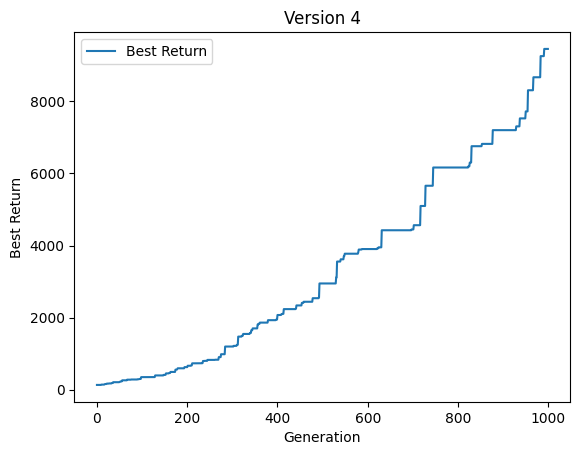

In [22]:

best_portfolio, generation_plot, best_return, end_time = Advanced_ES_V4(population_size, offspring_size, elitism_size, num_generations, num_assets, num_months)

analyze_convergence(generation_plot, end_time)
# Display final results
print("Best Return:", best_return)
print(f"Total Time: {end_time:.2f} seconds")
validate_and_plot(best_portfolio, generation_plot, num_months, title="Version 4", output_file="results/Version_4.png")
